### 1. Pipeline con transformadores personalizados y regresión lineal (Ridge)

**Aspectos avanzados:**

1. **Diseño de pipelines y composición de transformadores**  
   - Un `Pipeline` encapsula un flujo de preprocesamiento y modelado, lo que garantiza la aplicación consistente de cada paso.  
   - La clase `ColumnTransformer` posibilita aplicar transformaciones específicas a subconjuntos de columnas, permitiendo un preprocesamiento diferenciado (numérico vs. categórico).

2. **Transformaciones de variables (LogTransformer y RobustScaler)**  
   - La **transformación logarítmica** (`LogTransformer`) es útil cuando las variables presentan distribución fuertemente asimétrica (colas largas). Reducir la asimetría favorece métodos que asumen distribución más cercana a la normalidad y disminuye el efecto de outliers.  
   - El **escalado robusto** (`RobustScaler`) utiliza medidas robustas de tendencia central (mediana) y dispersión (IQR). A diferencia de la estandarización clásica (que utiliza media y desviación estándar), este escalado es menos sensible a valores atípicos (outliers).

3. **Creación de características polinómicas (PolynomialFeatures)**  
   - Añadir términos polinómicos de grado 2 captura relaciones no lineales entre las variables. En problemas complejos, estos términos pueden ayudar al modelo lineal a incrementar su poder de ajuste (aunque se debe vigilar el sobreajuste).  
   - La regularización (ver siguiente punto) es clave para controlar el aumento de dimensionalidad que implica esta expansión polinómica.

4. **Regresión lineal regularizada (Ridge)**  
   - Ridge (o **regresión L2**) penaliza la suma de los cuadrados de los coeficientes.  
   - Matemáticamente, la función de coste para Ridge se expresa como:  
     $$
     \min_{\beta} \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_j x_{ij})^2 + \alpha \sum_{j=1}^{p} \beta_j^2
     $$
     donde $\alpha$ controla la fuerza de la regularización.  
   - La regularización Ridge reduce la varianza del estimador, ayudando a mitigar el sobreajuste, a costa de aumentar ligeramente el sesgo.

5. **Búsqueda de hiperparámetros (GridSearchCV) y validación cruzada**  
   - La estrategia **grid search** recorre de forma exhaustiva un conjunto discreto de valores de hiperparámetros, con **validación cruzada** (CV) en cada combinación para estimar la métrica de rendimiento.  
   - Esto asegura que el mejor conjunto de parámetros no quede sobreajustado al conjunto de entrenamiento original, sino que se seleccione con base en múltiples particiones.

6. **Análisis de residuos y métricas**  
   - Las métricas como MSE, MAE y R2 informan sobre la bondad del ajuste en distintos sentidos:  
     - **MSE** penaliza más fuertemente grandes errores (debido al cuadrado).  
     - **MAE** es una métrica más robusta a outliers (errores grandes no se penalizan de manera cuadrática).  
     - **R2** mide la proporción de varianza explicada, con valores cercanos a 1 indicando mejor ajuste.


Mejores hiperparámetros: {'preprocessor__num__poly__degree': 2, 'regressor__alpha': 0.1}
MSE: 3.826
MAE: 1.548
R2 Score: 0.940


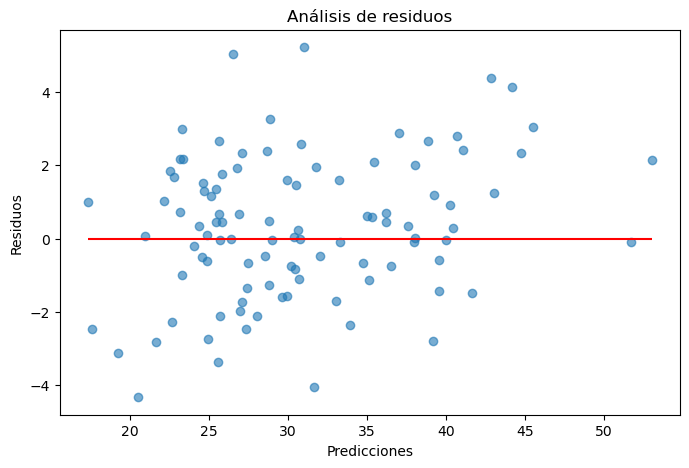

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   LogTransformer(column_names=['feature1',
                                                                                                'feature2'],
                                                                                  variables=['feature1'])),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['feature1', 'feature2']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D86466B740>))]),
                                                  ['category'])])),
                ('regressor', Ridge(alpha=0.1))])

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer, RobustScaler, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generar un dataset sintético
np.random.seed(42)
n_samples = 500
X_num = pd.DataFrame({
    'feature1': np.random.exponential(scale=2, size=n_samples),
    'feature2': np.random.normal(loc=50, scale=10, size=n_samples)
})
X_cat = pd.DataFrame({
    'category': np.random.choice(['A', 'B', 'C'], size=n_samples)
})
y = 3*X_num['feature1'] + 0.5*X_num['feature2'] + np.random.normal(scale=2, size=n_samples)

data = pd.concat([X_num, X_cat], axis=1)
data['target'] = y

# Transformador personalizado para aplicar logaritmo a variables asimétricas
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, column_names=None):
        """
        Parámetros:
          variables: lista de nombres de columna a transformar.
          column_names: lista de nombres de columna, en caso de que la entrada sea un array.
        """
        self.variables = variables
        self.column_names = column_names

    def fit(self, X, y=None):
        # Si X es DataFrame, almacenar sus columnas
        if isinstance(X, pd.DataFrame):
            self.column_names_ = X.columns
        else:
            if self.column_names is not None:
                self.column_names_ = self.column_names
            else:
                raise ValueError("Si X no es DataFrame, debe proporcionar 'column_names'.")
        return self

    def transform(self, X):
        # Convertir a DataFrame si es necesario
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.column_names_)
        else:
            X = X.copy()
        for var in self.variables:
            # Agregar un pequeño valor para evitar log(0)
            X[var] = np.log1p(X[var])
        return X

# Definir las variables numéricas y categóricas
numeric_features = ['feature1', 'feature2']
categorical_features = ['category']

# Pipeline para variables numéricas
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # SimpleImputer devuelve un array, por lo que se pasan los nombres de columnas
    ('log', LogTransformer(variables=['feature1'], column_names=numeric_features)),
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Pipeline para variables categóricas
# Se utiliza squeeze() para convertir un DataFrame de una columna a una Series.
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  FunctionTransformer(lambda X: pd.get_dummies(X.squeeze()), validate=False))
])

# Preprocesamiento de columnas
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Pipeline final con modelo Ridge
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# División de datos
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Búsqueda de hiperparámetros
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0],
    # Se ajusta el grado polinómico en el paso 'poly' del pipeline numérico
    'preprocessor__num__poly__degree': [1, 2]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)

# Evaluación
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Análisis de residuos
residuos = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuos, alpha=0.6)
plt.hlines(0, min(y_pred), max(y_pred), colors='red')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Análisis de residuos")
plt.show()

import sklearn
sklearn.set_config(display='diagram')
# Visualizar el pipeline final (por ejemplo, el mejor estimador obtenido tras el GridSearchCV)
grid.best_estimator_

### 2. Pipeline para clasificación con KNN y SVM en datos desbalanceados

**Aspectos avanzados:**

1. **Desbalance de clases y métricas acordes**  
   - Cuando la proporción de clases está muy desbalanceada, la exactitud (accuracy) puede ser engañosa. Por ello, se usan métricas como F1-score (combina precisión y exhaustividad) y AUC-ROC (Evalúa la tasa de verdaderos positivos contra la de falsos positivos).

2. **Técnicas de sobremuestreo (SMOTE)**  
   - **SMOTE (Synthetic Minority Over-sampling Technique)** genera sintéticamente nuevas instancias para la clase minoritaria.  
   - A diferencia del sobre-muestreo aleatorio puro, SMOTE reduce el sobreajuste al crear ejemplos intermedios entre muestras existentes de la clase minoritaria.

3. **K-Nearest neighbors (KNN)**  
   - KNN no tiene fase de entrenamiento explícita; la clasificación se basa en la vecindad de cada punto.  
   - El parámetro `n_neighbors` controla la complejidad: valores pequeños → alta varianza (más sobreajuste); valores grandes → alta sesgo (suavización excesiva).

4. **Máquinas de vectores de soporte (SVM)**  
   - El objetivo de la SVM es maximizar el **margen** que separa las clases.  
   - La versión **kernelizada** (por ejemplo, RBF) proyecta los datos a un espacio de mayor dimensión para encontrar un hiperplano separador no lineal.  
   - El hiperparámetro `C` controla la penalización al error de clasificación. Un `C` grande busca minimizar la clasificación errónea (riesgo de sobreajuste); un `C` pequeño tolera más errores en aras de un margen mayor (riesgo de subajuste).

5. **Curvas ROC y matriz de confusión**  
   - La **Curva ROC** (Receiver Operating Characteristic) evalúa la sensibilidad (TPR) frente a la especificidad (1-FPR) para diferentes umbrales de decisión.  
   - La **matriz de confusión** provee una visión clara de cómo el modelo confunde la clase positiva con la negativa, facilitando un análisis detallado de errores.


Mejores hiperparámetros KNN: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Mejores hiperparámetros SVM: {'classifier__C': 5.0, 'classifier__kernel': 'rbf'}
KNN - F1-score: 0.786, AUC: 0.846


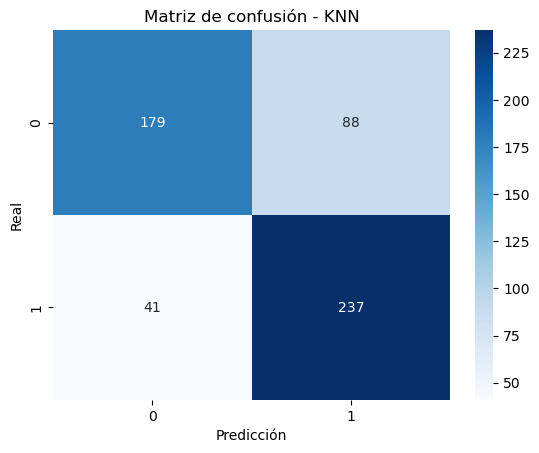

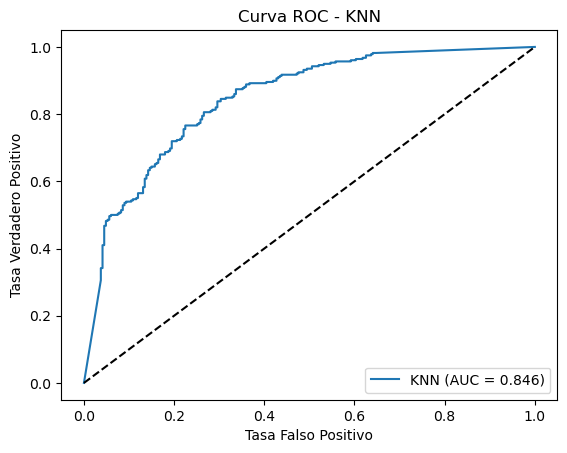

SVM - F1-score: 0.590, AUC: 0.630


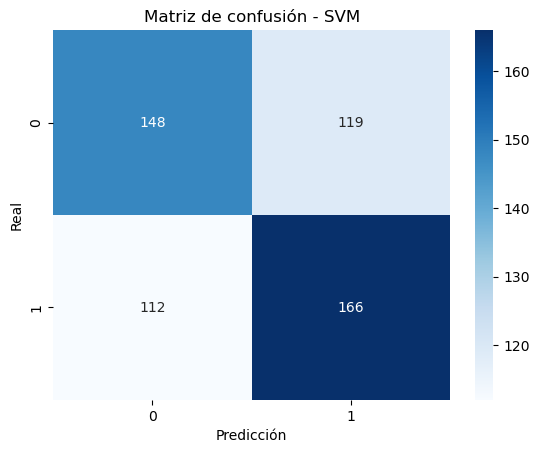

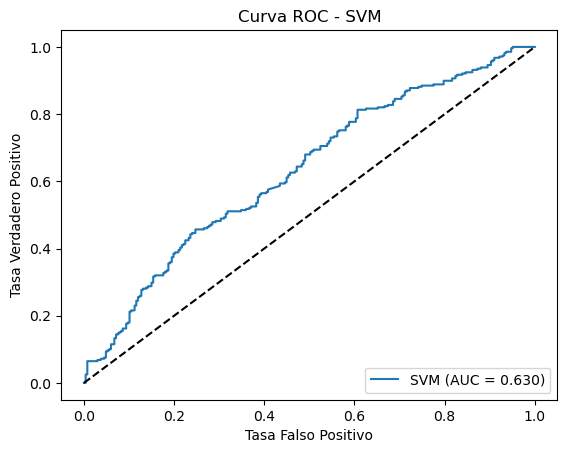

Pipeline(steps=[('imputer', SimpleImputer()), ('engineer', FeatureEngineer()),
                ('scaler', StandardScaler())])

In [5]:
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Generar datos sintéticos desbalanceados
np.random.seed(123)
n_samples = 1000
X_class = pd.DataFrame({
    'feat1': np.random.normal(0, 1, n_samples),
    'feat2': np.random.normal(5, 2, n_samples)
})
# Clase minoritaria: 10%, mayoritaria: 90%
y_class = np.where(np.random.rand(n_samples) < 0.1, 1, 0)

# Transformador personalizado para ingeniería de características
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convertir a DataFrame si es un ndarray
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=['feat1', 'feat2'])  # Asegurar nombres correctos
        
        # Crear una nueva feature: relación entre feat1 y feat2
        X['feat_ratio'] = X['feat1'] / (X['feat2'] + 1e-5)
        # Crear feature de interacción
        X['feat_interaction'] = X['feat1'] * X['feat2']
        
        return X


# Pipeline de preprocesamiento
preprocessor_cls = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('engineer', FeatureEngineer()),
    ('scaler', StandardScaler())
])

# Función para balancear datos con SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

# Preprocesamiento completo
X_processed = preprocessor_cls.fit_transform(X_class)
X_balanced, y_balanced = balance_data(pd.DataFrame(X_processed), y_class)

# Dividir datos balanceados
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Crear pipelines para KNN y SVM
pipeline_knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])
pipeline_svm = Pipeline([
    ('classifier', SVC(probability=True))
])

# Definir grids de hiperparámetros
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}
param_grid_svm = {
    'classifier__C': [0.5, 1.0, 5.0],
    'classifier__kernel': ['rbf', 'linear']
}

# Búsqueda de hiperparámetros
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='f1')
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='f1')

grid_knn.fit(X_train_cls, y_train_cls)
grid_svm.fit(X_train_cls, y_train_cls)

print("Mejores hiperparámetros KNN:", grid_knn.best_params_)
print("Mejores hiperparámetros SVM:", grid_svm.best_params_)

# Evaluación en test
for name, model in zip(['KNN', 'SVM'], [grid_knn, grid_svm]):
    y_pred = model.predict(X_test_cls)
    y_proba = model.predict_proba(X_test_cls)[:,1]
    f1 = f1_score(y_test_cls, y_pred)
    auc_val = roc_auc_score(y_test_cls, y_proba)
    print(f"{name} - F1-score: {f1:.3f}, AUC: {auc_val:.3f}")
    # Matriz de confusión
    cm = confusion_matrix(y_test_cls, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test_cls, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa Falso Positivo')
    plt.ylabel('Tasa Verdadero Positivo')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc="lower right")
    plt.show()

import sklearn
sklearn.set_config(display='diagram')
preprocessor_cls


### 3. Pipeline con árboles de decisión y ensamble

**Aspectos avanzados:**

1. **Selección de características basada en correlación**  
   - El transformador personalizado `CorrelationSelector` elimina aquellas variables que no superan un umbral de correlación medio, estrategia útil para disminuir dimensionalidad y ruido.  
   - Se podría combinar con otras técnicas (p. ej., selección basada en información mutua), pero el enfoque de correlación es un primer filtro simple y efectivo en muchos casos.

2. **Manejo de outliers mediante Winsorización**  
   - La **Winsorización** recorta los valores extremos a determinados percentiles. A diferencia de, por ejemplo, eliminar outliers, la Winsorización conserva todas las muestras y reduce la influencia de valores atípicos muy altos/bajos.  
   - Esto puede ser crítico en modelos basados en árboles, que son robustos en la partición del espacio, pero también en métodos lineales o basados en distancia.

3. **Modelos de árboles**  
   - **Árbol de decisión**: un modelo altamente interpretable, pero con tendencia al sobreajuste. Requiere parámetros como `max_depth`, `min_samples_split`, etc.  
   - **Random Forest**: combina múltiples árboles entrenados en muestras bootstrap con subconjuntos aleatorios de características. Reduce la varianza del modelo a costa de perder algo de interpretabilidad individual.  
   - **Gradient Boosting**: secuencialmente entrena “árboles débiles” que corrigen errores de predecesores. Tiende a sobreajustar menos que los árboles base y puede converger a soluciones muy precisas con tuning adecuado de `learning_rate` y `n_estimators`.

4. **Importancia de características**  
   - En modelos de árboles, la importancia de variables (basada en la reducción de impureza o de la función de pérdida) provee una medida de cuán relevante es cada predictor en la decisión.  
   - Sin embargo, hay que matizar que la importancia de características en árboles puede verse inflada para variables con muchos valores únicos o para variables altamente correlacionadas entre sí.

5. **Validación cruzada anidada (Nested CV)**  
   - Usada frecuentemente en problemas con muchos hiperparámetros para prevenir sobreajuste en la selección de modelos.  
   - Envuelve un **loop externo** de particionado de datos y un **loop interno** de búsqueda de hiperparámetros. Así, el conjunto de datos de prueba en la validación externa permanece intacta con respecto de la selección de hiperparámetros.

DecisionTree - Mejor Score: 1.000 | Mejores Hiperparámetros: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2}


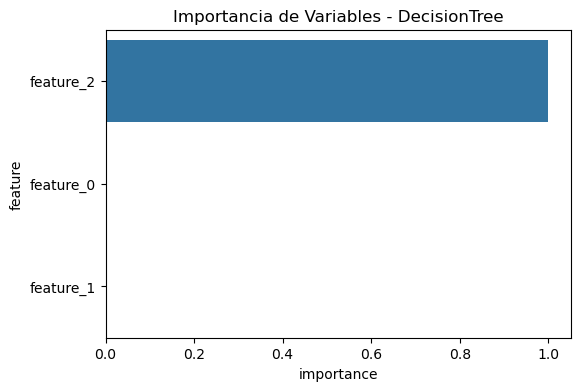

RandomForest - Mejor Score: 1.000 | Mejores Hiperparámetros: {'classifier__max_depth': None, 'classifier__n_estimators': 50}


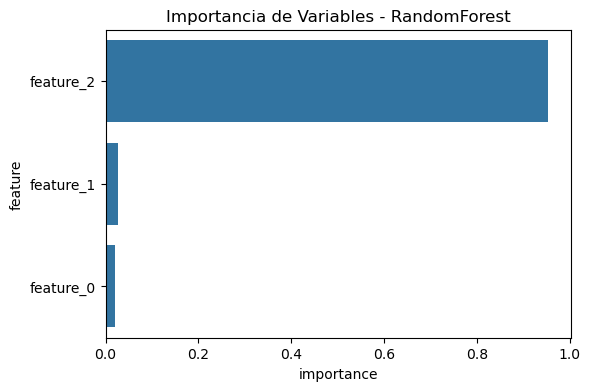

GradientBoosting - Mejor Score: 1.000 | Mejores Hiperparámetros: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}


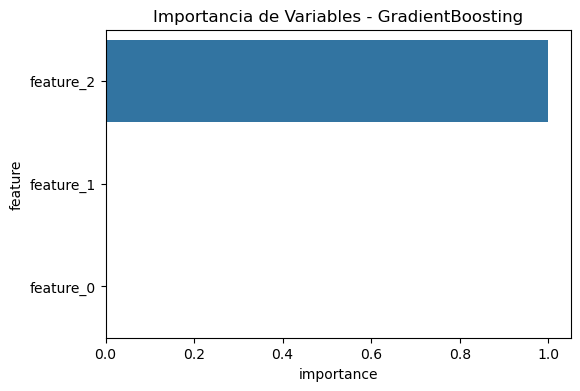

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('winsorizer', Winsorizer()),
                                 ('scaler', StandardScaler()),
                                 ('selector',
                                  CorrelationSelector(threshold=0.2))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone

# Generar dataset sintético para clasificación
np.random.seed(2021)
n_samples = 800
X_dt = pd.DataFrame({
    'age': np.random.randint(20, 70, n_samples),
    'income': np.random.normal(50000, 15000, n_samples),
    'score': np.random.uniform(300, 850, n_samples)
})
y_dt = np.where(X_dt['score'] > 600, 1, 0)

# Transformador personalizado para selección de features por correlación
class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Convertir X a DataFrame si es un ndarray
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

        corr = np.abs(np.corrcoef(X.T))
        self.features_ = X.columns[(corr.mean(axis=0) > self.threshold)].tolist()  # Convertir a lista
        return self

    def transform(self, X):
        # Convertir X a DataFrame si es un ndarray
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.features_)
            
        return X[self.features_]


# Transformador para Winsorización de outliers
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        # Convertir X a DataFrame si es un ndarray
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

        self.lower_bounds_ = X.quantile(self.lower_quantile)
        self.upper_bounds_ = X.quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X = X.copy()

        # Convertir a DataFrame si es necesario
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.lower_bounds_.index)

        for col in X.columns:
            X[col] = np.clip(X[col], self.lower_bounds_[col], self.upper_bounds_[col])
        return X


# Pipeline de preprocesamiento para datos numéricos
numeric_pipeline_dt = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer()),
    ('scaler', StandardScaler()),
    ('selector', CorrelationSelector(threshold=0.2))
])

# Definir modelos de árboles
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# Pipeline completo para cada modelo
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('preprocessor', numeric_pipeline_dt),
        ('classifier', model)
    ])

# Parámetros para GridSearch
param_grid_dt = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10]
}
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 5, 10]
}
param_grid_gb = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

grids = {
    'DecisionTree': GridSearchCV(pipelines['DecisionTree'], param_grid_dt, cv=5, scoring='f1'),
    'RandomForest': GridSearchCV(pipelines['RandomForest'], param_grid_rf, cv=5, scoring='f1'),
    'GradientBoosting': GridSearchCV(pipelines['GradientBoosting'], param_grid_gb, cv=5, scoring='f1')
}

# Entrenar y evaluar cada modelo
for name, grid in grids.items():
    grid.fit(X_dt, y_dt)
    print(f"{name} - Mejor Score: {grid.best_score_:.3f} | Mejores Hiperparámetros: {grid.best_params_}")
    # Obtener la importancia de las variables, si aplica
    best_model = grid.best_estimator_.named_steps['classifier']
    if hasattr(best_model, 'feature_importances_'):
        feature_names = grid.best_estimator_.named_steps['preprocessor'].named_steps['selector'].features_
        importances = best_model.feature_importances_
        df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
        df_imp = df_imp.sort_values(by='importance', ascending=False)
        plt.figure(figsize=(6,4))
        sns.barplot(x='importance', y='feature', data=df_imp)
        plt.title(f"Importancia de Variables - {name}")
        plt.show()

import sklearn
# Configurar scikit-learn para mostrar diagramas
sklearn.set_config(display='diagram')

# Visualizar el pipeline de RandomForest completo
pipelines['RandomForest']


#### 4. Pipeline de procesamiento de texto y clasificación con SVM

**Aspectos avanzados:**

1. **Limpieza y normalización de texto**  
   - El transformador `TextCleaner` ejecuta pasos de normalización: conversión a minúsculas, eliminación de caracteres no alfanuméricos, tokenización, eliminación de stopwords y stemming. Cada paso reduce ruido y mejora la señal semántica.

2. **Representación TF-IDF**  
   - **TF-IDF** (Term Frequency-Inverse Document Frequency) pondera la importancia de cada palabra en el documento considerando su frecuencia global.  
   - Formalmente, se calcula:  
     $$
     \text{tf-idf}(t, d) = \text{tf}(t, d) \times \log \frac{N}{\text{df}(t)}
     $$
     donde $\text{tf}(t, d)$ es la frecuencia del término $t$ en el documento $d$, $N$ es el total de documentos y $\text{df}(t)$ es el número de documentos que contienen $t$.  
   - Esto atenúa el efecto de palabras muy comunes (ej. "el", "la" en español) que no discriminan bien entre documentos.

3. **Reducción de dimensionalidad con TruncatedSVD**  
   - Análogo al **PCA** pero aplicado a matrices dispersas de conteos/TF-IDF. Reduce la dimensionalidad manteniendo la mayor varianza de los datos y acelerando el entrenamiento de modelos en espacios de alta dimensión.  
   - En el contexto de procesamiento de lenguaje natural (NLP), se acerca a la idea de **LSA (Latent Semantic Analysis)**, que captura correlaciones semánticas entre términos.

4. **Clasificador SVM para texto**  
   - Las SVM lineales son muy comunes en NLP gracias a que, en espacios de alta dimensión, un modelo lineal con regularización tiende a funcionar muy bien y ser eficiente.  
   - La elección de `kernel= linear` suele facilitar la interpretación (los coeficientes se asocian a palabras o conceptos del vocabulario).

5. **Visualización de clusters con la matriz reducida**  
   - Al proyectar TF-IDF a 2 dimensiones con SVD, puede verse cómo documentos con similar contenido semántico se agrupan en el plano.  
   - Esto ayuda a **interpretar** si la clase positiva/negativa se separa adecuadamente en ese espacio reducido (aunque no sea el mismo espacio final donde entrena el modelo SVM).


Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.83      0.50      0.40         3
weighted avg       0.78      0.67      0.53         3



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kapum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kapum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


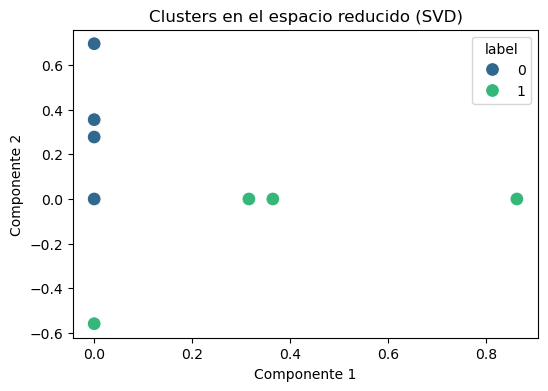

In [11]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Descarga de recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Datos de ejemplo: reseñas de producto (simulados)
text_data = pd.DataFrame({
    'review': [
        "El producto es excelente, superó mis expectativas.",
        "Muy malo, no funciona como se describe.",
        "La calidad es buena, pero el precio es alto.",
        "Deficiente, me decepcionó la compra.",
        "Es un producto decente, cumple lo básico.",
        "Increíble, lo recomiendo a todos.",
        "No me gustó, esperaba más calidad.",
        "Buen producto, excelente relación calidad-precio.",
        "Terrible, se rompió al poco tiempo de uso.",
        "Muy recomendable, superó mis expectativas."
    ],
    'label': [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]  # 1: positivo, 0: negativo
})

# Transformador personalizado para limpieza de texto
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, language='spanish'):
        self.stop_words = set(stopwords.words(language))
        self.stemmer = SnowballStemmer(language)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cleaned = []
        for doc in X:
            # Convertir a minúsculas y quitar caracteres especiales
            doc = doc.lower()
            doc = re.sub(r'[^a-záéíóúñ\s]', '', doc)
            tokens = nltk.word_tokenize(doc)
            tokens = [self.stemmer.stem(word) for word in tokens if word not in self.stop_words]
            cleaned.append(" ".join(tokens))
        return cleaned

# Pipeline para procesamiento de texto y clasificación
pipeline_text = Pipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(max_features=50)),
    ('svd', TruncatedSVD(n_components=2)),
    ('svm', SVC(kernel='linear', probability=True))
])

# División de datos (usando 'stratify' para asegurar la representación proporcional de clases)
X_text = text_data['review']
y_text = text_data['label']
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y_text, test_size=0.3, random_state=42, stratify=y_text
)

# Entrenar el pipeline
pipeline_text.fit(X_train_text, y_train_text)
y_pred_text = pipeline_text.predict(X_test_text)

print("Reporte de clasificación:")
print(classification_report(y_test_text, y_pred_text, zero_division=1))

# Visualización de clusters en el espacio reducido
# Se aplica el transformador 'cleaner' y 'tfidf' manualmente para toda la data
tfidf_matrix = pipeline_text.named_steps['tfidf'].transform(
    pipeline_text.named_steps['cleaner'].transform(X_text)
)
svd_matrix = pipeline_text.named_steps['svd'].transform(tfidf_matrix)

plt.figure(figsize=(6,4))
sns.scatterplot(x=svd_matrix[:, 0], y=svd_matrix[:, 1], hue=y_text, palette='viridis', s=100)
plt.title("Clusters en el espacio reducido (SVD)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()




#### 5. Pipeline multisalida para regresión y clasificación simultánea

**Aspectos avanzados:**

1. **Concepto de multisalida (multioutput)**  
   - Un problema multisalida combina, en un solo conjunto de predictores, una tarea de regresión y otra de clasificación (o múltiples regresiones/clasificaciones).  
   - Un ejemplo real: predecir la edad (regresión) y el rango etario (clasificación) a partir de una misma serie de características biométricas.

2. **Preprocesamiento diferencial para cada tarea**  
   - En el ejemplo, un transformador personalizado (`DualPreprocessor`) aplica un escalado distinto (StandardScaler vs. RobustScaler) para las dos tareas.  
   - Esto ilustra cómo puede diseñarse una lógica que permita *dividir* el espacio de features en dos enfoques de preprocesamiento (uno para la regresión y otro para la clasificación), preservando la consistencia interna del Pipeline.

3. **MultiOutputRegressor**  
   - Cuando se tienen múltiples variables objetivo de tipo continuo, `MultiOutputRegressor` envuelve un regressor base para manejar cada uno.  
   - Aunque aquí se muestra un caso sencillo (una sola variable de regresión y otra de clasificación), el esquema MultiOutput es especialmente útil al manejar varios targets correlacionados (p. ej., predecir ventas de distintos productos).

4. **Métricas y evaluación conjunta**  
   - Se entrena y evalúa simultáneamente la parte de regresión y la de clasificación. Cada una requiere sus propias métricas: MSE, R2 para regresión y accuracy/F1 para clasificación.  
   - Esto evidencia la importancia de diseñar un método de partición apropiado (como `train_test_split` duplicado o mayor sofisticación con validación cruzada estratificada, etc.) para garantizar evaluaciones justas en ambas tareas.

5. **Relación entre predicción continua y probabilidad de clase**  
   - Es interesante analizar cómo la salida regresiva (p. ej., un valor continuo de renta, puntaje u otra métrica) se relaciona con la probabilidad de pertenecer a la clase positiva.  
   - En problemas más complejos, pueden hallarse correlaciones o patrones en cómo cierta variable continua se correlaciona con la probabilidad de un suceso (por ejemplo, a mayor ingreso, mayor probabilidad de comprar un producto premium).

Mejores hiperparámetros para clasificación: {'classifier__C': 0.1, 'classifier__gamma': 'auto'}
Evaluación de regresión:
MSE: 27.11850100573048
R2: 0.9920874566209017
Evaluación de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        85
           1       0.99      0.99      0.99        95

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



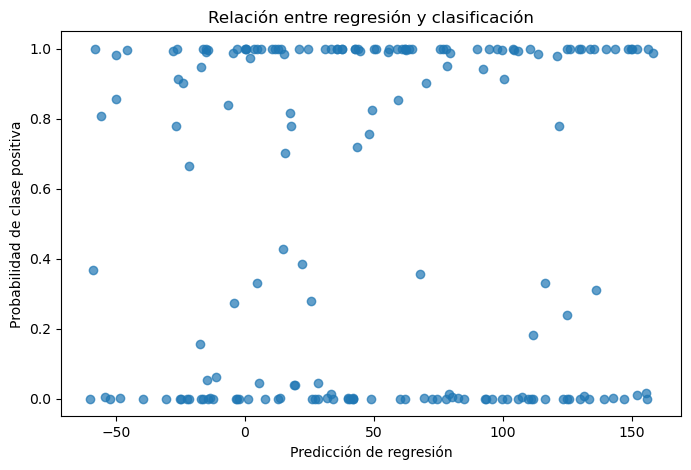

Pipeline(steps=[('regressor', LinearRegression())])

In [13]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

# Generar dataset sintético multisalida
np.random.seed(0)
n_samples = 600
X_multi = pd.DataFrame({
    'f1': np.random.uniform(0, 100, n_samples),
    'f2': np.random.uniform(50, 150, n_samples),
    'f3': np.random.normal(0, 1, n_samples)
})
# Tarea de regresión: predecir un valor continuo
y_reg = 2*X_multi['f1'] - 0.5*X_multi['f2'] + np.random.normal(0, 5, n_samples)
# Tarea de clasificación: clasificar en dos clases basadas en una función de X
y_clf = np.where(X_multi['f3'] > 0, 1, 0)

# Transformador personalizado para preprocesamiento diferencial
class DualPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler_reg = StandardScaler()
        self.scaler_clf = RobustScaler()
    def fit(self, X, y=None):
        self.scaler_reg.fit(X)
        self.scaler_clf.fit(X)
        return self
    def transform(self, X):
        X_reg = pd.DataFrame(self.scaler_reg.transform(X), columns=X.columns)
        X_clf = pd.DataFrame(self.scaler_clf.transform(X), columns=X.columns)
        return X_reg, X_clf

# Aplicar el transformador
dual_preproc = DualPreprocessor()
X_reg_proc, X_clf_proc = dual_preproc.fit_transform(X_multi)

# Dividir datos para ambas tareas
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg_proc, y_reg, test_size=0.3, random_state=42)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf_proc, y_clf, test_size=0.3, random_state=42)

# Crear pipelines para ambas tareas
pipeline_reg = Pipeline([
    ('regressor', LinearRegression())
])
pipeline_clf = Pipeline([
    ('classifier', SVC(kernel='rbf', probability=True))
])

# Definir grids de hiperparámetros para clasificación
param_grid_clf = {
    'classifier__C': [0.1, 1.0, 10],
    'classifier__gamma': ['scale', 'auto']
}
grid_clf = GridSearchCV(pipeline_clf, param_grid_clf, cv=5, scoring='f1')
grid_clf.fit(X_clf_train, y_clf_train)
print("Mejores hiperparámetros para clasificación:", grid_clf.best_params_)

# Entrenar regresión y clasificación
pipeline_reg.fit(X_reg_train, y_reg_train)
grid_clf.best_estimator_.fit(X_clf_train, y_clf_train)

# Evaluación de regresión
y_reg_pred = pipeline_reg.predict(X_reg_test)
print("Evaluación de regresión:")
print("MSE:", mean_squared_error(y_reg_test, y_reg_pred))
print("R2:", r2_score(y_reg_test, y_reg_pred))

# Evaluación de clasificación
y_clf_pred = grid_clf.best_estimator_.predict(X_clf_test)
print("Evaluación de clasificación:")
print(classification_report(y_clf_test, y_clf_pred))

# Análisis conjunto: relación entre la predicción de regresión y la probabilidad de la clase positiva
y_clf_proba = grid_clf.best_estimator_.predict_proba(X_clf_test)[:,1]
plt.figure(figsize=(8,5))
plt.scatter(y_reg_pred, y_clf_proba, alpha=0.7)
plt.xlabel("Predicción de regresión")
plt.ylabel("Probabilidad de clase positiva")
plt.title("Relación entre regresión y clasificación")
plt.show()

import sklearn
sklearn.set_config(display='diagram')
pipeline_reg


### 6. Pipeline avanzado con stacking regressor, selección de características y transformadores personalizados

Mejores hiperparámetros encontrados:
{'stack__final_estimator__alpha': 0.1, 'stack__gb__n_estimators': 50, 'stack__rf__n_estimators': 50}
Mejor puntuación (MSE negativo): -1083.459

--- Métricas en Test ---
MSE  : 1247.092
MAE  : 15.309
R^2  : 0.076


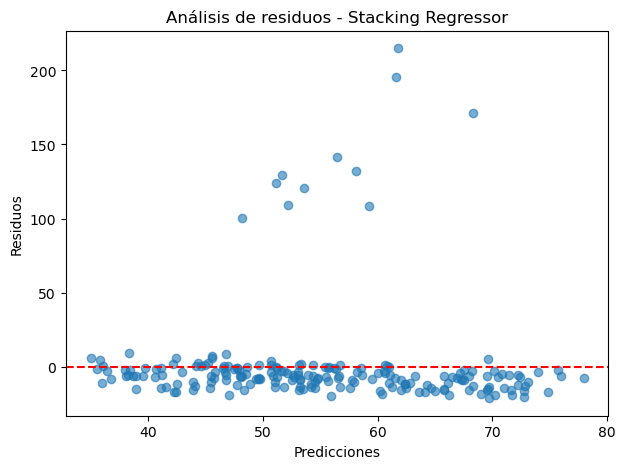

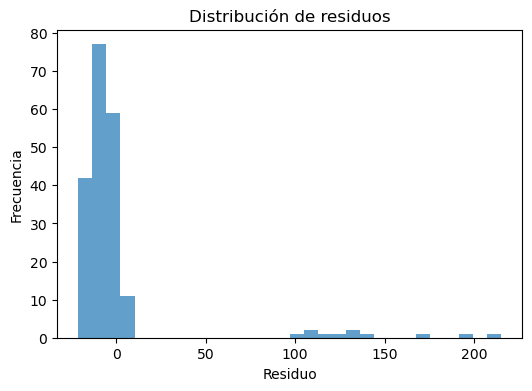

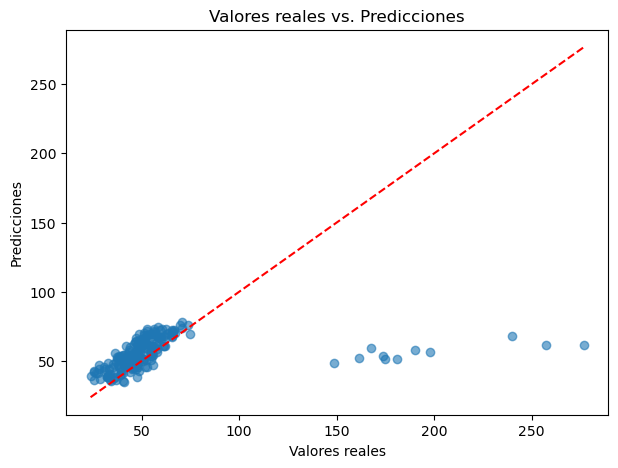


Features seleccionadas:
['X2', 'X3', 'X4', 'X1_X3']

Las importancias medias utilizadas en la selección determinaron las features finales.
Para más detalles, inspeccione manualmente los estimators en 'best_model.named_steps['stack'].estimators_'.


Pipeline(steps=[('imputer', SimpleImputer()),
                ('dataframe_converter',
                 DataFrameConverter(columns=Index(['X1', 'X2', 'X3', 'X4'], dtype='object'))),
                ('winsor', CustomWinsorizer()),
                ('featcreator', FeatureCreator()),
                ('scaler', DataFrameStandardScaler()),
                ('feature_selector',
                 MultiModelFeatureSelector(n_estimators=30)),
                ('stack',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(n_estimators=50,
                                                                      random_state=42)),
                                               ('gb',
                                                GradientBoostingRegressor(n_estimators=50,
                                                                          random_state=42)),
                                               ('svr', SVR())],
                                   final_estimator=Ridge()))])

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------------------------------
# 1. Generar un dataset sintético complejo con componentes lineales y no lineales
# --------------------------------------------------------------------------------
np.random.seed(2025)
n_samples = 1000

# Variables con diferentes distribuciones
X1 = np.random.exponential(scale=2, size=n_samples)
X2 = np.random.normal(loc=50, scale=10, size=n_samples)
X3 = np.random.uniform(0, 100, n_samples)
X4 = np.random.gamma(shape=2.0, scale=5.0, size=n_samples)

# Combinamos en un DataFrame
df_features = pd.DataFrame({
    'X1': X1, 
    'X2': X2, 
    'X3': X3, 
    'X4': X4
})

# Creamos una variable objetivo compleja con interacciones no lineales y ruido
y_target = 3.5 * np.sqrt(X1) + 0.8 * X2 - 0.02 * X3 * X1 + 2 * np.log1p(X4) + np.random.normal(scale=5, size=n_samples)

# Introducimos valores atípicos en el 5% de los casos
mask_outliers = np.random.choice([False, True], size=n_samples, p=[0.95, 0.05])
y_target[mask_outliers] *= 4

# --------------------------------------------------------------------------------
# 2. Dividir en entrenamiento y prueba
# --------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df_features, y_target, test_size=0.2, random_state=42
)

# --------------------------------------------------------------------------------
# 3. Creación de transformadores personalizados
# --------------------------------------------------------------------------------

# 3a. CustomWinsorizer modificado para preservar DataFrame
class CustomWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, quantile_lower=0.01, quantile_upper=0.99):
        self.quantile_lower = quantile_lower
        self.quantile_upper = quantile_upper

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.lower_bounds_ = X.quantile(self.quantile_lower)
            self.upper_bounds_ = X.quantile(self.quantile_upper)
        else:
            X_df = pd.DataFrame(X)
            self.lower_bounds_ = X_df.quantile(self.quantile_lower)
            self.upper_bounds_ = X_df.quantile(self.quantile_upper)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_clipped = X.copy()
        for col in X_clipped.columns:
            lower = self.lower_bounds_[col]
            upper = self.upper_bounds_[col]
            X_clipped[col] = X_clipped[col].clip(lower=lower, upper=upper)
        return X_clipped

# 3b. FeatureCreator para generar características adicionales
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, use_log_transform=['X1'], create_interactions=True):
        self.use_log_transform = use_log_transform
        self.create_interactions = create_interactions
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Aplicar transformaciones logarítmicas a ciertas columnas
        for col in self.use_log_transform:
            X[f'log_{col}'] = np.log1p(X[col])
        # Crear interacciones y potencias
        if self.create_interactions:
            if 'X1' in X.columns and 'X3' in X.columns:
                X['X1_X3'] = X['X1'] * X['X3']
                X['X1^2'] = X['X1'] ** 2
        return X

# 3c. MultiModelFeatureSelector para la selección de características
class MultiModelFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, n_estimators=50, random_state=42):
        self.threshold = threshold
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):
        self.models = [
            RandomForestRegressor(n_estimators=self.n_estimators, random_state=self.random_state),
            GradientBoostingRegressor(n_estimators=self.n_estimators, random_state=self.random_state)
        ]
        importances = []
        self.features_ = X.columns
        for model in self.models:
            model.fit(X, y)
            importances.append(model.feature_importances_)
        mean_importances = np.mean(importances, axis=0)
        self.selected_features_ = self.features_[mean_importances > self.threshold]
        return self

    def transform(self, X):
        return X[self.selected_features_]

# 3d. DataFrameConverter para asegurar que los datos tengan etiquetas de columna
class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        if self.columns is None:
            if isinstance(X, pd.DataFrame):
                self.columns = X.columns
            else:
                raise ValueError("No se proporcionaron columnas y X no es DataFrame.")
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X
        return pd.DataFrame(X, columns=self.columns)

# 3e. DataFrameStandardScaler que conserva DataFrame y sus etiquetas
class DataFrameStandardScaler(StandardScaler, TransformerMixin):
    def transform(self, X, copy=None):
        # Escalar los datos usando el método de StandardScaler
        X_scaled = super().transform(X)
        # Si X es DataFrame, reconstruirlo con los mismos índices y columnas
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
        else:
            return X_scaled

# --------------------------------------------------------------------------------
# 4. Crear un pipeline de preprocesamiento y modelado con Stacking
# --------------------------------------------------------------------------------

# Modelos base para el Stacking
estimators = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
    ('svr', SVR(kernel='rbf'))
]

# Meta-modelo final
final_estimator = Ridge()

# Definir el StackingRegressor
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator
)

# Construir el pipeline asegurando que se preserven las etiquetas de columna
pipeline_stacking = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('dataframe_converter', DataFrameConverter(columns=X_train.columns)),
    ('winsor', CustomWinsorizer(quantile_lower=0.01, quantile_upper=0.99)),
    ('featcreator', FeatureCreator(use_log_transform=['X1'], create_interactions=True)),
    ('scaler', DataFrameStandardScaler()),
    ('feature_selector', MultiModelFeatureSelector(threshold=0.05, n_estimators=30)),
    ('stack', stacking_reg)
])

# --------------------------------------------------------------------------------
# 5. Búsqueda de hiperparámetros con GridSearchCV
# --------------------------------------------------------------------------------

param_grid = {
    'stack__rf__n_estimators': [50, 80],
    'stack__gb__n_estimators': [50, 80],
    'stack__final_estimator__alpha': [0.1, 1.0, 10]
}

grid_search = GridSearchCV(
    estimator=pipeline_stacking,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"Mejor puntuación (MSE negativo): {grid_search.best_score_:.3f}")

# --------------------------------------------------------------------------------
# 6. Evaluación en el conjunto de prueba
# --------------------------------------------------------------------------------

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("\n--- Métricas en Test ---")
print(f"MSE  : {mse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R^2  : {r2:.3f}")

# --------------------------------------------------------------------------------
# 7. Análisis de residuos y visualizaciones
# --------------------------------------------------------------------------------

residuos = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Análisis de residuos - Stacking Regressor")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuos, bins=30, alpha=0.7)
plt.title("Distribución de residuos")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')  # Línea ideal y=x
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs. Predicciones")
plt.show()

# Visualizar las features seleccionadas
selector = best_model.named_steps['feature_selector']
print("\nFeatures seleccionadas:")
print(selector.selected_features_.tolist())

print("\nLas importancias medias utilizadas en la selección determinaron las features finales.")
print("Para más detalles, inspeccione manualmente los estimators en 'best_model.named_steps['stack'].estimators_'.")

import sklearn
sklearn.set_config(display='diagram')
pipeline_stacking



### Ejercicios

#### Ejercicio 1: Construcción de un pipeline con preprocesamiento mixto

**Objetivo:**  
Crear un pipeline que procese datos con variables numéricas y categóricas.

**Instrucciones:**  
- Utiliza un dataset (puede ser sintético o real) que contenga tanto variables numéricas como categóricas.  
- Implementa un pipeline que incluya:  
  - Imputación de valores faltantes en variables numéricas y categóricas.  
  - Aplicación de un escalador robusto para variables numéricas.  
  - Codificación one-hot para variables categóricas (puedes usar `OneHotEncoder` o una función personalizada).  
- Realiza una búsqueda de hiperparámetros con `GridSearchCV` para ajustar un modelo de regresión (por ejemplo, Ridge o Lasso).  
- Evalúa el rendimiento utilizando métricas como MSE y R2, y visualiza los residuos.

#### Ejercicio 2: Desarrollo de un transformador personalizado para Winsorización  
**Objetivo:**  
Implementar y validar un transformador personalizado que realice Winsorización para el manejo de outliers.

**Instrucciones:**  
- Crea una clase que herede de `BaseEstimator` y `TransformerMixin`.  
- La clase deberá recortar los valores de cada característica por debajo y por encima de percentiles definidos (por ejemplo, 5% y 95%).  
- Integra este transformador en un pipeline junto con un escalador y un modelo (por ejemplo, RandomForestRegressor).  
- Entrena el pipeline en un conjunto de datos sintético con outliers intencionales y compara el rendimiento del modelo con y sin Winsorización.


#### Ejercicio 3: Pipeline con ingeniería de características y stacking regressor  
**Objetivo:**  
Combinar transformaciones personalizadas con un modelo de ensamblaje (Stacking) en un pipeline.

**Instrucciones:**  
- Genera un dataset sintético que contenga relaciones no lineales y algunas interacciones entre las variables.  
- Crea un transformador personalizado que genere nuevas variables (por ejemplo, transformaciones logarítmicas, interacciones o términos polinómicos).  
- Construye un pipeline que incluya:  
  - Imputación de datos.  
  - Transformación personalizada de características.  
  - Escalado de datos.  
  - Un `StackingRegressor` que combine, al menos, tres modelos base (por ejemplo, RandomForest, SVR y GradientBoosting) y un meta-modelo lineal.  
- Realiza una búsqueda de hiperparámetros utilizando `GridSearchCV` para ajustar parámetros en los modelos base y el meta-modelo.  
- Evalúa el pipeline en un conjunto de prueba, calculando métricas como MSE, MAE y R2, y visualiza los resultados.


#### Ejercicio 4: Comparación de pipelines y evaluación de modelos  
**Objetivo:**  
Comparar diferentes enfoques de preprocesamiento y modelos en un mismo conjunto de datos.

**Instrucciones:**  
- Selecciona un dataset que pueda ser utilizado para regresión o clasificación.  
- Construye al menos dos pipelines distintos, por ejemplo:  
  - Pipeline A: Con preprocesamiento básico (imputación, escalado) y un modelo simple (como regresión lineal o SVM).  
  - Pipeline B: Con transformadores personalizados (por ejemplo, winsorización, ingeniería de características) y un modelo más complejo (por ejemplo, un ensamble o un StackingRegressor/Classifier).  
- Usa `GridSearchCV` para ajustar los hiperparámetros de ambos pipelines.  
- Evalúa el rendimiento de cada pipeline con métricas apropiadas y realiza un análisis comparativo (por ejemplo, mediante validación cruzada, análisis de residuos, curvas ROC en el caso de clasificación, etc.).


In [ ]:
## Tus respuestas